In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, AlphaDropout, BatchNormalization, Add, concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size':15})

In [2]:
# Read all datasets
test_feat = pd.read_csv('data/test_features.csv')
train_drug = pd.read_csv('data/train_drug.csv')
train_feat = pd.read_csv('data/train_features.csv')
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv')
train_targets_scored = pd.read_csv('data/train_targets_scored.csv')

# Categorical to numerical
train_feat.cp_time = train_feat.cp_time.map({24: 1, 48: 2, 72: 3}).astype(int)
train_feat = pd.get_dummies(train_feat, columns=['cp_type'], prefix="cp_type", drop_first=True)
train_feat = pd.get_dummies(train_feat, columns=["cp_dose"], prefix="cp_dose", drop_first=True)

# Actually this test_features.csv has no targets and is used for making prediction and submitting as submission.csv
# for competition scoring purpose. If I am not going to submit, then it's useless.
test_feat.cp_time = test_feat.cp_time.map({24: 1, 48: 2, 72: 3}).astype(int)
test_feat = pd.get_dummies(test_feat, columns=["cp_type"], prefix="cp_type", drop_first=True)
test_feat = pd.get_dummies(test_feat, columns=["cp_dose"], prefix="cp_dose", drop_first=True)

# Get X, y using train datasets
X = train_feat.drop('sig_id', axis=1).values
y = train_targets_scored.drop('sig_id', axis=1).values

In [3]:
n_components = 70
pca70 = PCA(n_components=n_components)
X_pca70 = pca70.fit_transform(X)

# first split into train_all and test, latter is used as holdout data.
X_pca70_train_all, X_pca70_test, y_train_all, y_test = train_test_split(X_pca70, y, test_size=0.20, shuffle=True, random_state=1)

# then split train_all to train and val, the former is used as train data, and the latter is used as validation data.
X_pca70_train, X_pca70_val, y_train, y_val = train_test_split(X_pca70_train_all, y_train_all, test_size=0.20, random_state=1)

# X_pca70_train_reshaped = X_pca70_train.reshape(X_pca70_train.shape[0], X_pca70_train.shape[1], 1)
# X_pca70_val_reshaped = X_pca70_val.reshape(X_pca70_val.shape[0], X_pca70_val.shape[1], 1)

In [4]:
X_pca70_train.shape, X_pca70_val.shape, X_pca70_test.shape, y_train.shape, y_val.shape, y_test.shape

((15240, 70), (3811, 70), (4763, 70), (15240, 206), (3811, 206), (4763, 206))

In [5]:
# Need to define the log-loss metric required by the competition, see formula here:
# https://www.kaggle.com/c/lish-moa/overview/evaluation
def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 0.001, 0.999)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [6]:
def logloss_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return log_loss(y, y_pred) / y.shape[1]  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                4544      
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 206)               26574     
Total params: 39,694
Trainable params: 39,566
Non-trainable params: 128
________________________________________________

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
477/477 [==============================] - 2s 4ms/step - loss: 0.1538 - logloss: 0.1518 - val_loss: 0.0222 - val_logloss: 0.0190

Epoch 00001: loss improved from inf to 0.05974, saving model to models/mlp_base
INFO:tensorflow:Assets written to: models/mlp_base/assets
Epoch 2/50
477/477 [==============================] - 2s 4ms/step - loss: 0.0225 - logloss: 0.0193 - val_loss: 0.0211 - val_logloss: 0.0179

Epoch 00002: loss improved from 0.05974 to 0.02236, saving model to models/mlp_base
INFO:tensorflow:Assets written to: models/mlp_base/assets
Epoch 3/50
477/477 [==============================] - 2s 4ms/step - loss: 0.0215 - logloss: 0.0183 - val_loss: 0.0205 - val_logloss: 0.0174

Epoch 00003: loss improved from 0.02236 to 0.02147, saving model to models/mlp_base
INFO:tensorflow:Assets written to: models/mlp_base/assets
Epoch 4/50
477/477 [==============================] - 2s 4ms/step - loss: 0.0210 - logloss: 0.0178 - val_loss: 0.0202 - val_logloss: 0.0171

Epoch 00004: l

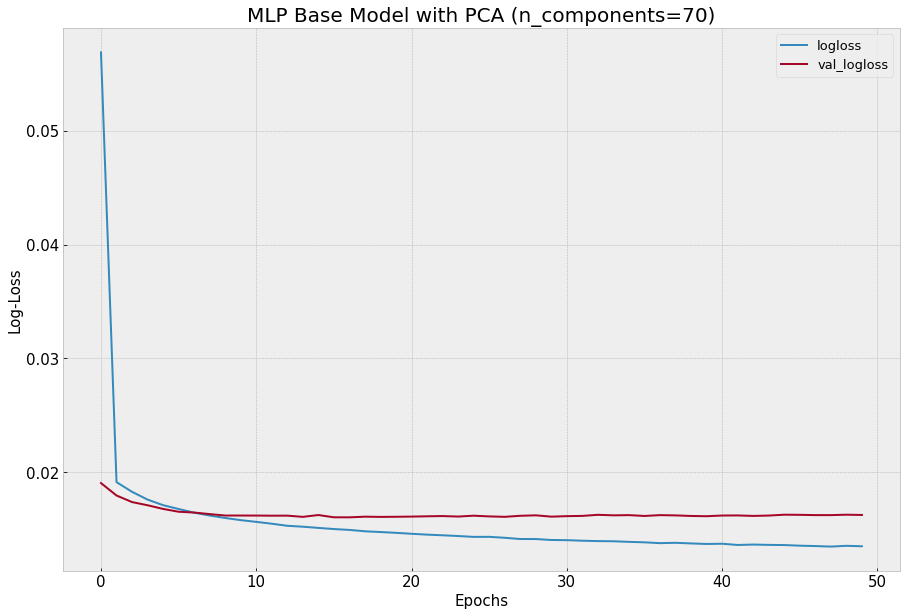

In [26]:
start = time.time()


# Build a basic MLP model first
def build_model(n_cols):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(n_cols,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu' ))
    #model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model 

n_cols = X_pca70_train.shape[1]
mlp_base = build_model(n_cols)
mlp_base.summary()

earlystp_mlp_base = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/mlp_base'
checkpoint_mlp_base = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

history_mlp_base = mlp_base.fit(
    X_pca70_train, y_train, batch_size=32,
    validation_data=(X_pca70_val, y_val),
    epochs=50,
    callbacks=[checkpoint_mlp_base, earlystp_mlp_base, TqdmCallback()])

score = mlp_base.evaluate(X_pca70_val, y_val, verbose=0)
print('Validation log-loss: ', score[1])

mlp_base.save('models/mlp_base_complete')

fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_mlp_base.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Log-Loss', fontsize=15)
ax.set_title('MLP Base Model with PCA (n_components=70)', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/mlp_base.jpg')


# calculate the running time
end = time.time()
print("Total running time:", round((end - start)/60, 1), 'minutes')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                4544      
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)                256       
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)              

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/500
477/477 [==============================] - 3s 5ms/step - loss: 0.5650 - logloss: 0.5646 - val_loss: 0.0346 - val_logloss: 0.0326

Epoch 00001: loss improved from inf to 0.31677, saving model to models/mlp_final
INFO:tensorflow:Assets written to: models/mlp_final/assets
Epoch 2/500
477/477 [==============================] - 2s 5ms/step - loss: 0.0312 - logloss: 0.0289 - val_loss: 0.0228 - val_logloss: 0.0200

Epoch 00002: loss improved from 0.31677 to 0.02797, saving model to models/mlp_final
INFO:tensorflow:Assets written to: models/mlp_final/assets
Epoch 3/500
477/477 [==============================] - 2s 5ms/step - loss: 0.0238 - logloss: 0.0210 - val_loss: 0.0217 - val_logloss: 0.0187

Epoch 00003: loss improved from 0.02797 to 0.02373, saving model to models/mlp_final
INFO:tensorflow:Assets written to: models/mlp_final/assets
Epoch 4/500
477/477 [==============================] - 2s 5ms/step - loss: 0.0227 - logloss: 0.0197 - val_loss: 0.0213 - val_logloss: 0.0181

Epoc

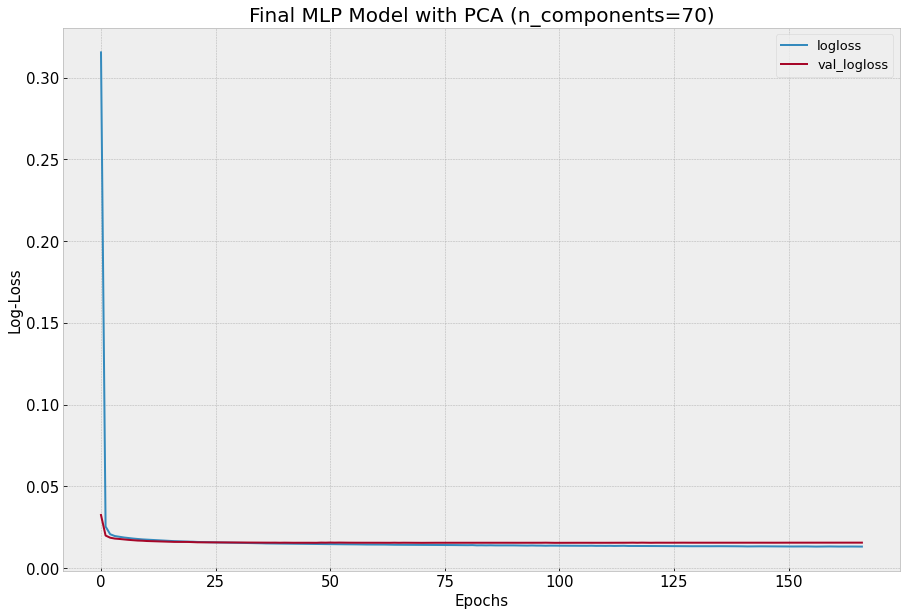

In [27]:
# To record running time
start = time.time()

# build final model with optimized hyperparameters, print model summary
def mlp_model(n_cols):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(n_cols,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.0005, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model 

n_cols = X_pca70_train.shape[1]
mlp_final = mlp_model(n_cols)
mlp_final.summary()

# setup callbacks for fitting
earlystp_mlp_final = EarlyStopping(monitor='loss', patience=10)
filepath = 'models/mlp_final'
checkpoint_mlp_final = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# fit the model
history_mlp_final = mlp_final.fit(
    X_pca70_train, y_train, batch_size=32,
    validation_data=(X_pca70_val, y_val),
    epochs=500,
    callbacks=[checkpoint_mlp_final, earlystp_mlp_final, TqdmCallback()])

# evaluate model with validation data
score = mlp_final.evaluate(X_pca70_val, y_val, verbose=0)
print('Validation log-loss: ', score[1])

# save the model
mlp_final.save('models/mlp_final_complete')

# plot training history of the model
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_mlp_final.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Log-Loss', fontsize=15)
ax.set_title('Final MLP Model with PCA (n_components=70)', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/mlp_final.jpg')

# calculate the running time
end = time.time()
print("Total running time:", (end - start)/60, 'minutes')


In [28]:
y_test_pred = mlp_final.predict(X_pca70_test)
y_test_pred.shape

(4763, 206)

In [29]:
y_test_pred[0,:]

array([1.36697010e-04, 4.70693485e-05, 5.86554001e-04, 6.56699203e-03,
       1.71924122e-02, 6.12986786e-03, 2.88768695e-03, 2.94942921e-03,
       8.12326733e-04, 3.57446237e-03, 2.27452181e-02, 3.99197997e-05,
       6.12148666e-04, 1.83927623e-04, 4.06681036e-04, 2.16046625e-04,
       7.82408810e-04, 3.62232997e-04, 2.48386385e-03, 3.62175587e-03,
       2.21170369e-04, 1.32340996e-03, 2.65598734e-04, 4.56925307e-04,
       4.64811048e-04, 3.18813400e-04, 6.25319604e-04, 1.89898390e-04,
       4.28688247e-03, 1.34421373e-03, 1.38700008e-03, 3.16108810e-04,
       2.40230715e-04, 2.68325966e-04, 5.09782461e-04, 4.89285216e-04,
       3.85499239e-04, 1.83884476e-04, 2.84794587e-05, 6.11656753e-04,
       2.80364067e-04, 6.87301101e-04, 1.15555688e-03, 5.82390372e-03,
       2.03681667e-03, 2.84656859e-03, 1.36086674e-04, 9.45566135e-05,
       1.99476010e-04, 1.06683921e-03, 1.75958930e-03, 3.37862817e-04,
       1.06867788e-04, 3.98968696e-04, 9.05678794e-03, 7.16081867e-03,
      

In [30]:
logloss_ = logloss(y_test, y_test_pred)
logloss_

<tf.Tensor: shape=(), dtype=float32, numpy=0.01590645>

Final logloss on holdout data is 0.0159